# Word Vector Embeddings

The intuition behind this title eponymously aims at representing a word as a vector.

There are primarily two stable techniques of achieving the above objective
- Word2Vec
- GloVe

## Word2Vec

Word2Vec is a neural network learning system which learns representations of word as a vector using a single hidden layer MLP over a large corpus of text where the output of a word fed to the MLP is the probabilities of co-occurence of all other words within a specific given window size of this word.  

*We can then use the activations of the hidden layer neurons to represent each word uniquely as a vector of the same dimensions as the number of neurons in hidden layer.*

**WHY?**

After the MLP has trained and learned to identify the cooccurence probabilities, we could say that the *hidden layer is capturing the nature of relationship of a word with every other word in terms of the cooccurence probabilites.* Though it is theoretically possible to express a word as a co-occurence probability vector but typically it's size is huge and that's why we refrain from doing that. Instead we use the hidden layer with 50-300 neurons typically to work in a low dimensional space and capture the vector representation in a smaller space.

**Use**:
- Regulatities emerge and nature of relationships is captured well. You can understand the same from the image below.

![Word Vector Relationships](WordVectors.png)

[Source here](https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/)
- As a preprocessing step for learning to do tasks related to text i.e. classification, prediction, caption generation, text auto-completion etc. 

**NOTE**: The above method of training a Word2Vec model is called skipgram model and there's also another method called CBOW (Continuous Bag of Words) model which you can refer from the Source mentioned above near the image.

## GloVe

GloVe is eventually obtaining the same result as a Word2Vec model only difference being the way in which it achieves the task i.e. use of Matrix Factorization.

A GloVe model optimization function is expresses as below:

* Constraint - $w_iw_j + b_i + b_j = log(X_{ij})$ where i and j are ith and jth words.

* Optimize(minimize) - $ Loss = \Sigma_1^N\Sigma_1^Nf(X_{ij})(w_iw_j + b_i + b_j - log(X_{ij}))^2$ for all i and j.

Here $f(X_{ij}) = (\frac{X_{ij}}{X_{max}})^\alpha for X_{ij} < X_{max} \mbox{ and 1 otherwise}$

This function is basically weighting the losses in proportion to their occurence in the corpus a certain i.e. $X_{max}$ number of times. If the frequency exceeds $X_{max}$ then every word is weighted to be equally important

The optimization algorithm is not Gradient Descent but some other method. 

# Scope of this notebook

To use GloVe 
- to understand Word Embeddings 
- to demonstrate encoded relationships between words 
- to use embeddings for text classification

In [25]:
# To perform file operations and to
# To randomly sample a word from the GloVe corpus
import os
import random

# To perform matrix & vector operations
# To perform data related operations
import numpy as np
import pandas as pd

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For splitting data into train and tst and to evaluate
# the classification using Confusion Matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [52]:
# For preprocessing the text
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# For building the keras model
from keras.layers import Dense, Flatten, Dropout, Embedding
from keras.models import Sequential

# For selecting the optimization algorithm
from keras.optimizers import Adam

In [54]:
learning_rate = 0.01
num_epochs = 50

In [2]:
# Get the name of the current directory
curr_dir = os.getcwd()

# Define an empty dictionary to hold the embeddings
embeddings_index = {}

# Open the file containing all the word vector representations
f = open(os.path.join(curr_dir, 'glove_6B_50d.txt'), encoding="utf-8")

# Iterate over each line in my file
for line in f:
    # All elements are comma separated, get them in an array.
    values = line.split()
    
    # First element is the word itself on each line. Grab it.
    word = values[0]
    
    # All remaining values are the 50 embedded values for that word
    coefs = np.asarray(values[1:], dtype='float32')
    
    # Insert this word with it's vector representation in our dictionary
    embeddings_index[word] = coefs
f.close()

print(f'Extracted {len(embeddings_index)} word vectors from the file')

Extracted 400000 word vectors from the file


# Relationship extraction

Let's pick a random word from the embeddings dictionary and find out the closest 5 words which relate to it. 

Since we have vector representations, words which appear in similar context will be closer to one another and we're exploiting that fact by taking dot-product of vectors and lining them in descending order of importance to figure out close neighbors.

The following functions from numpy will help find out the normalized dot product between two words.

`np.linalg.norm` - This helps compute the magnitude of a vector expressed as an `np.array`

`np.dot` - This finds out the dot product between the two vectors passed as `np.array`

In [3]:
RandomWord = random.choice(list(embeddings_index.keys()))
print(RandomWord)

35-nation


In [4]:
RandomWordEmbedding = embeddings_index[RandomWord]
print(f"The first ten entries in the embedded vector for {RandomWord} are\n")
print(RandomWordEmbedding[:10])

The first ten entries in the embedded vector for 35-nation are

[ 0.29981  -0.024924  0.48867  -0.47128   0.36121  -1.1452    1.1198
  0.41651   1.1251   -0.070459]


## Similar words extraction

In [5]:
def compute_normalized_dot_product(vec1, vec2):
    # Compute dot product between the two vectors
    dot_prod = np.dot(vec1, vec2)
    
    # Compute magnitudes of the vectors
    mag1 = np.linalg.norm(vec1)
    mag2 = np.linalg.norm(vec2)
    
    # Normalize the dot product    
    norm_dot_prod = dot_prod / (mag1 * mag2)
    
    return norm_dot_prod

In [6]:
similarities = {}

for i in embeddings_index.keys():
    NewWordEmbedding = embeddings_index[i]
    similarities[i] = compute_normalized_dot_product(RandomWordEmbedding, NewWordEmbedding)

In [7]:
print(f"Top 10 words similar to {RandomWord} are as follows:")
print(sorted(similarities, key = lambda x:similarities[x],  reverse = True)[:10])

Top 10 words similar to 35-nation are as follows:
['35-nation', '35-member', '11-member', '24-member', '12-member', '13-member', 'ifab', '22-member', '18-member', 'lawmaking']


## Relationship extraction on basis of gender

Let's see if words male and female exist in our corpus and based on the relationship between them, let's find the word which is most related to 

- bachelor
- king
- monsieur

if they exist in the corpus.

The way we're gonna do this is get the direction vector from male to female. 

This should give us the relationship vector which points in general from a male entity to a female entity. If the relationship is captured, then if we take vectors for a male common noun and add this relationship to it, we expect to get a reasonably close female common noun. Let's try it out!

In [8]:
for i in ['male', 'female', 'bachelor', 'king', 'monsieur']:
    print(i, i in embeddings_index.keys())

male True
female True
bachelor True
king True
monsieur True


In [20]:
def extract_relation(base, direction_vector):
    
    # Find the new vector
    new_word_embedding = embeddings_index[base] + direction_vector
    
    similarities = {}
    
    # Compute the similarities of base word with respect to each word in corpus
    for i in embeddings_index.keys():
        dict_word = embeddings_index[i]
        similarities[i] = compute_normalized_dot_product(new_word_embedding, dict_word)
        
    # Sort in descending order of similarity and remove the first word since 
    # The first word is definitely going to be the base word itself as any word
    # is most similar to itself.
    top_5 = sorted(similarities, key = lambda x:similarities[x],  reverse = True)[1:6] 
    
    # Print the top 5 most similar words based on dot product
    print(f"\n{base} is most similar to these five words with respect to the direction_vector's relationship")
    print(top_5)
    
    # Visualize the similarities in a horizontal bar chart.
    sim_score = [similarities[i] for i in top_5]
    sns.barplot(x = top_5, y = sim_score)
    plt.suptitle(f'Words similar to {base}')
    plt.xlabel('Words')
    plt.ylabel('Similarity scores')
    plt.show()


king is most similar to these five words with respect to the direction_vector's relationship
['queen', 'daughter', 'prince', 'throne', 'princess']


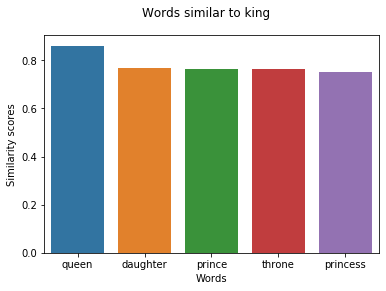


monsieur is most similar to these five words with respect to the direction_vector's relationship
['magda', 'croque', 'beaucaire', 'antoinette', 'staël']


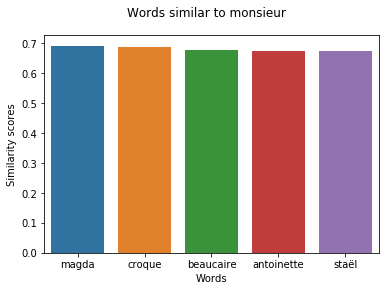


male is most similar to these five words with respect to the direction_vector's relationship
['female', 'adult', 'adults', 'unmarried', 'women']


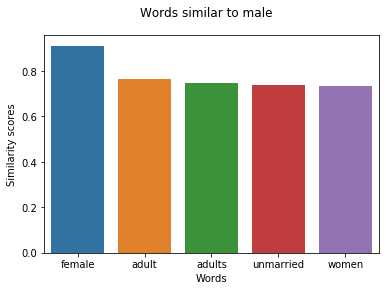


princess is most similar to these five words with respect to the direction_vector's relationship
['duchess', 'queen', 'sister', 'countess', 'bride']


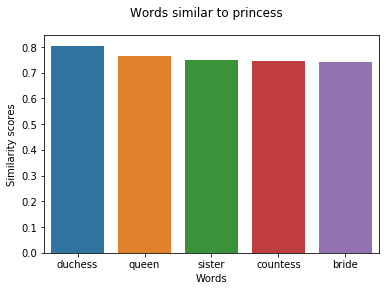


guy is most similar to these five words with respect to the direction_vector's relationship
['mom', 'woman', 'dad', 'waitress', 'loves']


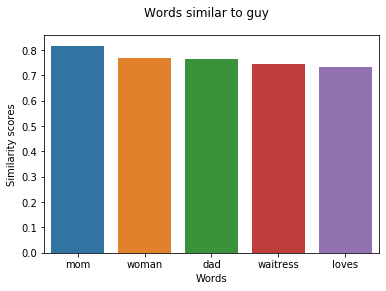

In [21]:
for i in ['king', 'monsieur', 'male', 'princess', 'guy']:
    relation = embeddings_index['woman'] - embeddings_index['man']
    extract_relation(i, relation)

The above relationship is reasonably fair in capturing the relationship if we see.

- King-Queen
- Male-Female
- guy-woman
- monsieur(man) - antoinette(lady's name) [Probably the corpus doesn't have many French words to train on] 

give a sense of relationship similar to that between a man and a woman

## Relationship extraction on basis of Tense

Similar to the gender relationship above, we could test our hypotheses based on the tenses. Let's find out the relationship between 'is' and 'was' and see if we can use it to map other present tense verbs to their past tense forms.

In [15]:
for i in ['is', 'was']:
    print(i, i in embeddings_index.keys())

is True
was True



drink is most similar to these five words with respect to the direction_vector's relationship
['drink', 'drinks', 'drunk', 'drinking', 'beer']


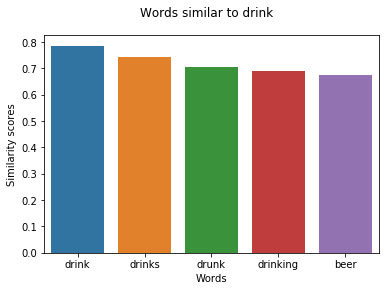


walk is most similar to these five words with respect to the direction_vector's relationship
['went', 'walk', 'stayed', 'stopped', 'ran']


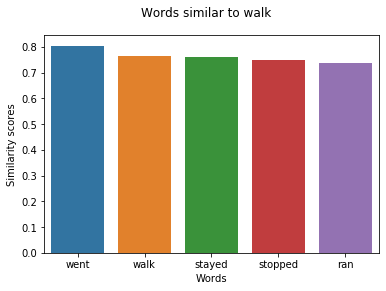


swim is most similar to these five words with respect to the direction_vector's relationship
['swim', 'raced', 'rowed', 'swum', 'swimmers']


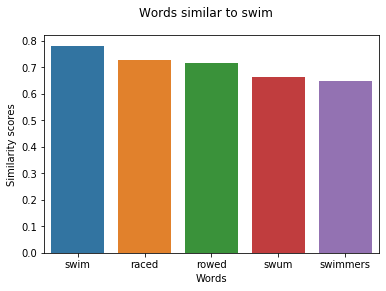


eat is most similar to these five words with respect to the direction_vector's relationship
['eat', 'eaten', 'eating', 'sick', "'d"]


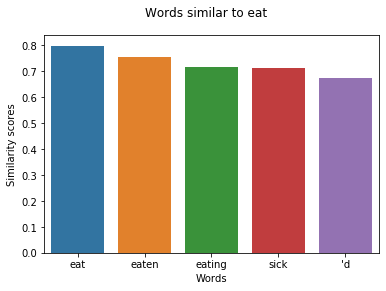


bite is most similar to these five words with respect to the direction_vector's relationship
['bitten', 'biting', 'throat', 'wound', 'bites']


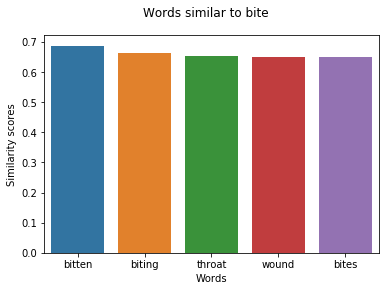

In [22]:
for i in ['drink', 'walk', 'swim', 'eat', 'bite']:
    relation = embeddings_index['was'] - embeddings_index['is']
    extract_relation(i, relation)

Again we see there's a good similarity here between the words and their tense representations.  

- Drink - drunk
- Walk - went or ran (It's capturing tense but changing root verb, yet quite accurate in a way)
- Swim - swum
- Eat - eaten (I expected ate but eaten is also used with other past forms and is a valid word).
- Bite - bitten

These are enough examples to show the effectiveness of word embeddings and justify their use in different ANN models to do lots of interesting tasks.

# Text Classification with predefined Embeddings in Keras 

Similar to how we built an embedding layer in keras to distinguish positive reviews from negative ones for the `amazon_cells_labelled.txt` review data, let's do that by using the word embeddings which we obtained from GloVe above.

We will not train these embeddings and keep them fixed and use another dense layer in conjunction with this to figure out the relationships between positive and negative text.

We will load the data, tokenize it using `Tokenizer.fit_on_texts()` method in keras, encode every sentence into integer indices using `Tokenizer.text_to_sequences`, find the max length word and pad the sentence lengths to the max length using `pad_sequences` similar to how we'd done in the notebook **Text_Classification_Embeddings_Keras.ipynb**. 

Post this, there's a step we need to additionally perform before model building which I've described below.

In [23]:
data = pd.read_table('amazon_cells_labelled.txt', header = None)
data.columns = ['Text', 'Reviews']
pd.set_option('display.max_colwidth', -1)
print(f"Size of the data is: {data.shape}")
data.head()

Size of the data is: (1000, 2)


,Text,Reviews
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0
4,The mic is great.,1


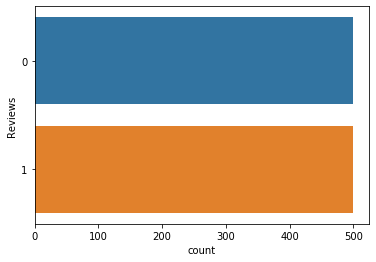

In [24]:
sns.countplot(y = "Reviews", data = data)
plt.show()

In [27]:
X = data.Text; y = data.Reviews
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.05, random_state = 0)

In [28]:
# Tokenization
Tk = Tokenizer()
Tk.fit_on_texts(X_train)

# Watch how big is the vocabulary
print(f"There are {len(Tk.word_index)} unique words in our vocabulary.")

There are 1838 unique words in our vocabulary.


In [29]:
# Define the vocabulary size accordingly
vocab_size = len(Tk.word_index) + 1
print(f"Our text vocabulary is of size {vocab_size}.")

Our text vocabulary is of size 1839.


In [30]:
# Encode all the sentences in our data to convert them into integer index representations.
encoded_train = Tk.texts_to_sequences(X_train)
encoded_test = Tk.texts_to_sequences(X_test)

In [31]:
# The integer index coded representation for each review is as follows
[print(i) for i in encoded_train[:5]]

[181, 9]
[2, 257, 36, 7, 54, 114, 1, 534, 5, 781]
[535, 93, 2, 324]
[2, 83, 100, 55, 107, 14, 7, 24]
[1, 122, 398, 1, 9, 325, 17, 3, 123, 56, 108, 1, 168, 326, 226, 3, 1, 115, 11, 37, 4, 782, 536, 783]


[None, None, None, None, None]

In [32]:
# Let's find out the length of the biggest review for padding purposes
max_length_train = max([len(i) for i in encoded_train])
max_length_test = max([len(i) for i in encoded_test])

max_length = max(max_length_train, max_length_test)

print(f"The biggest review has {max_length} number of words present in it.")

The biggest review has 30 number of words present in it.


In [33]:
# Pad the documents to the maximum length for keras to accept input while building a model
padded_train = pad_sequences(encoded_train, maxlen = max_length, padding = 'post')
padded_test = pad_sequences(encoded_test, maxlen = max_length, padding = 'post')

# Top 5 results in padded train sequence. 
# We can see that each and every review has been padded with 0s at it's 
# end to bring the lengths of all the datapoints on the same baseline
[print(i) for i in padded_train[:5]]

[181   9   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]
[  2 257  36   7  54 114   1 534   5 781   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]
[535  93   2 324   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]
[  2  83 100  55 107  14   7  24   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]
[  1 122 398   1   9 325  17   3 123  56 108   1 168 326 226   3   1 115
  11  37   4 782 536 783   0   0   0   0   0   0]


[None, None, None, None, None]

# Extract Vocabulary Embeddings

We are primarily interested only in the embeddings in our train vocabulary. Let's hunt these words in our `embeddings_index` dictionary and extract the word vectors for these words.

In [36]:
# Initialize a weight matrix for words in training docs
# 50 because our embedding is of length 50
embedding_matrix = np.zeros((vocab_size, 50))

for word, i in Tk.word_index.items():
    # Use .get() method of a dictionary to find the embeddings for a word
    # If the word isn't a key in the dictionary, we'd get a None in return
    embedding_vector = embeddings_index.get(word)
    
    # Store the embedding if there's one
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [42]:
# Look at word embeddings of any random 5 words from our embedding matrix
r = np.random.randint(vocab_size)
embedding_matrix[r:r + 5]

array([[ 0.21962   ,  0.62506002,  0.036481  ,  0.91399997,  0.62923002,
         0.27533999,  0.8452    ,  0.17431   ,  0.14024   ,  0.15263   ,
         0.17178001,  0.32126001, -0.84736001,  0.30199999,  0.47670999,
         0.018174  , -0.14233001,  0.37933001, -0.94545001, -0.42623001,
         0.25975001, -0.85088003,  0.14590999,  0.49066001, -0.81854999,
        -1.75979996, -0.30318001,  0.52275997,  0.45216   , -1.26160002,
         1.94200003, -0.24123   ,  0.011121  , -0.25734001, -0.24916001,
         0.56998003,  0.13335   , -0.33596   , -0.34742001,  0.058454  ,
         0.35159001,  0.36493999, -0.51073998,  0.57172   ,  0.23325001,
        -1.05299997,  0.49458   , -1.35899997, -0.3418    , -0.81897998],
       [-0.17581999, -0.046832  , -0.39719   , -0.15842   ,  0.83589   ,
        -0.078353  ,  0.74071002, -0.58925998, -1.01960003,  1.08039999,
         0.25988001, -0.15267   ,  1.23839998,  0.15435   , -0.32442001,
        -0.065147  , -1.33969998, -0.33191001, -0.

We see that the embeddings are populated aptly in the embedding matrix and it's not all zeros. 

# Model Architecture

Our training data has a vocabulary size of 1839.

Each input has 30 words or 30 tokens associated with it.

GloVe provides a 50 dimensional vector representation for every word which will be our output dimension for embedding layer.

There are 30 such words per datapoint which means we'll be getting 30 * 50 = 1500 output activations which need to be flattened to bring them into one single layer which can be fed to the next FC layer for doing binary classification.

Let's construct this model using the `Sequential` API in keras

**NOTE: Embedding layer parameters**:

- input_dim - It is the size of our vocabulary (1839 in our case).
- input_length - Length of input sequences (30 in our case).
- output_dimension - Dimension of the dense embedding (50 which GloVe has provided).

**NOTE : Embedding layer will be set to a non-trainable layer since those are pre-set word representations obtained from glove_6B_50d.txt by Stanford**

[Refer this link](https://keras.io/layers/embeddings/) for details about several other parameters which we won't be using here.

In [74]:
# Note we've given trainable parameter = False for maintaining the embeddings we got from GloVe
# Also, adding Dropout since the model otherwise overfits
model = Sequential([
    Embedding(input_dim = vocab_size, input_length = max_length, 
              weights = [embedding_matrix], output_dim = 50, trainable = False),
    Flatten(),
    Dropout(rate = 0.2),
    Dense(1, activation = 'sigmoid')
])

In [75]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 30, 50)            91950     
_________________________________________________________________
flatten_6 (Flatten)          (None, 1500)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1500)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1501      
Total params: 93,451
Trainable params: 1,501
Non-trainable params: 91,950
_________________________________________________________________


Since each sentence/review is only 30 words long and each word is described by 50 neuron activations, we get the training parameters of the NN architecture in the first layer to be 30 * 50 = 1500 which are flattened with `Flatten` layer.

Evenetually we have a `Dense` layer which does the job of classifying the reviews into 1s(positive) or 0s(negative)

Let's now compile the model and use adam with learning rate 0.01 to optimize the loss. 

In [76]:
# compile the model
model.compile(optimizer=Adam(lr = learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Fit and Evaluate the Model

In [77]:
model.fit(padded_train, y_train, epochs = num_epochs, verbose = 1, 
          validation_split = 0.2, batch_size = 32)

Train on 760 samples, validate on 190 samples
Epoch 1/50
760/760 [==============================] - 0s 502us/step - loss: 0.6683 - accuracy: 0.6224 - val_loss: 0.5925 - val_accuracy: 0.7316
Epoch 2/50
760/760 [==============================] - 0s 89us/step - loss: 0.4534 - accuracy: 0.7961 - val_loss: 0.5976 - val_accuracy: 0.7158
Epoch 3/50
760/760 [==============================] - 0s 100us/step - loss: 0.4028 - accuracy: 0.8342 - val_loss: 0.6163 - val_accuracy: 0.7105
Epoch 4/50
760/760 [==============================] - 0s 99us/step - loss: 0.3621 - accuracy: 0.8526 - val_loss: 0.6020 - val_accuracy: 0.7474
Epoch 5/50
760/760 [==============================] - 0s 110us/step - loss: 0.3598 - accuracy: 0.8474 - val_loss: 0.6217 - val_accuracy: 0.7474
Epoch 6/50
760/760 [==============================] - 0s 120us/step - loss: 0.3114 - accuracy: 0.8842 - val_loss: 0.6326 - val_accuracy: 0.7263
Epoch 7/50
760/760 [==============================] - 0s 79us/step - loss: 0.2944 - accuracy

# Performance Evaluation on Train and Test

In [78]:
def evaluate_performance(y_true, y_pred, title, labels):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"Accuracy:  {np.round((tp + tn) / (tp + fp + tn + fn), 3)}")
    print(f"Recall:    {np.round(tp / (tp + fn), 3)}")
    print(f"Precision: {np.round(tp / (tp + fp), 3)}")
    print(f"f1 score:  {np.round(2 * tp / (2 * tp + fp + fn), 3)}\n")
    
    data = confusion_matrix(y_true, y_pred)
    data = pd.DataFrame(data/np.sum(data), index = labels, columns = labels)
    print(data)
    akws = {"ha": 'center',"va": 'center', 'size':15}
    sns.heatmap(data, annot = True, annot_kws=akws)
    plt.suptitle(title)
    plt.xticks(rotation = 90); plt.yticks(rotation = 0)
    plt.show()

**Evaluate on Train** 

Accuracy:  0.921
Recall:    0.922
Precision: 0.92
f1 score:  0.921

          Negative  Positive
Negative  0.460000  0.040000
Positive  0.038947  0.461053


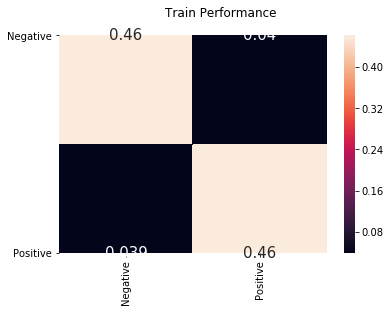

In [79]:
y_pred_train = model.predict_classes(padded_train)
evaluate_performance(y_train, y_pred_train, title = 'Train Performance',
                     labels = ['Negative', 'Positive'])

**Evaluate on Test**

Accuracy:  0.58
Recall:    0.68
Precision: 0.567
f1 score:  0.618

          Negative  Positive
Negative  0.24      0.26    
Positive  0.16      0.34    


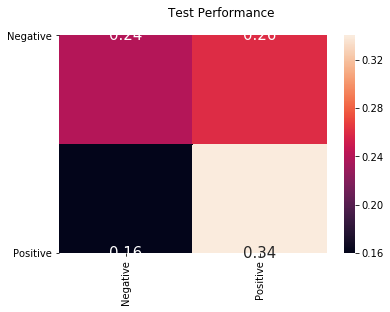

In [80]:
y_pred_test = model.predict_classes(padded_test)
evaluate_performance(y_test, y_pred_test, title = 'Test Performance',
                     labels = ['Negative', 'Positive'])

# Experimenting with training the embedding layer

We saw that the model doesn't perform well and overfits if we keep the training for Embedding layer as False even after adding regularization using dropout. Let's try to also simultaneously train the embedding layer and see if there's any improvement in the performance.

In [83]:
model = Sequential([
    Embedding(input_dim = vocab_size, input_length = max_length, 
              weights = [embedding_matrix], output_dim = 50, trainable = True),
    Flatten(),
    Dropout(rate = 0.2),
    Dense(1, activation = 'sigmoid')
])

print(model.summary())

model.compile(optimizer=Adam(lr = learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(padded_train, y_train, epochs = num_epochs, verbose = 1, 
          validation_split = 0.2, batch_size = 32)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 30, 50)            91950     
_________________________________________________________________
flatten_9 (Flatten)          (None, 1500)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1500)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 1501      
Total params: 93,451
Trainable params: 93,451
Non-trainable params: 0
_________________________________________________________________
None
Train on 760 samples, validate on 190 samples
Epoch 1/50
760/760 [==============================] - 0s 561us/step - loss: 0.6888 - accuracy: 0.6105 - val_loss: 0.5596 - val_accuracy: 0.7263
Epoch 2/50
760/760 [==============================] -

Performance on Train data
Accuracy:  0.961
Recall:    0.952
Precision: 0.97
f1 score:  0.961

          Negative  Positive
Negative  0.485263  0.014737
Positive  0.024211  0.475789


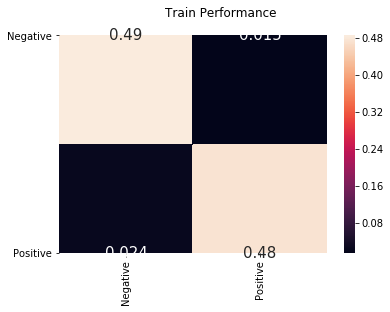

Performance on Test data
Accuracy:  0.88
Recall:    0.92
Precision: 0.852
f1 score:  0.885

          Negative  Positive
Negative  0.42      0.08    
Positive  0.04      0.46    


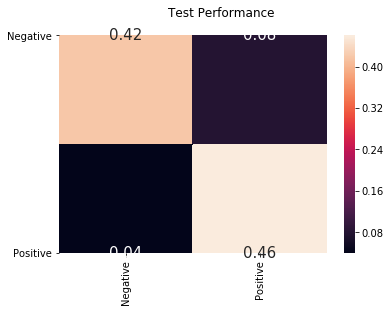

In [84]:
print("Performance on Train data")

y_pred_train = model.predict_classes(padded_train)
evaluate_performance(y_train, y_pred_train, title = 'Train Performance',
                     labels = ['Negative', 'Positive'])

print("Performance on Test data")
y_pred_test = model.predict_classes(padded_test)
evaluate_performance(y_test, y_pred_test, title = 'Test Performance',
                     labels = ['Negative', 'Positive'])

# Conclusion

In this notebook, we saw

- What are word vector embeddings and two most commonly used methods i.e. GloVe and Word2Vec

- How to use Word Vector Embeddings
    - To extract similarities
    - To extract relationships between words
    - To represent a word as a vector to feed them to different ANN models
    
Finally we observed that a 50-Dimensional representation learned on a huge corpus doesn't have word vector weights in a good enough local minima because of which we were not able to classify positive reviews from negative ones properly. 

But when we allowed training to happen on these weights, they became tuned to the task at hand thereby they learned better.